<table align="center" width=100%>
    <tr>
        <td>
            <div align="center">
                <font color="green" size=24px>
                    <b> DNS-Hackathon-2023-Notebook
                    </b>
                </font>
            </div>
        </td>
    </tr>
</table>

<br>




## 1 Overview

This dataset contains consists of 14,000 property listings for training and 6,000 for testing.

Each listing is described by seven features:

1. ID: A unique identifier for each property. This feature, being an identifier, likely has no predictive power and can be dropped from the modeling process.

2. loc (Location): The geographical location of each property. With approximately 12,187 non-null entries, there seem to be missing values that need to be addressed during the data cleaning process. This feature could have significant predictive power as property prices are often highly dependent on location.

3. title (Type): This refers to the type of property (e.g., duplex, apartment, etc.). It has around 12,278 non-null entries, indicating potential missing values that need to be filled or handled appropriately. The type of property can affect its price, so this could be an important feature.

4. bedroom: The number of bedrooms in the property. This feature has approximately 12,201 non-null entries. Bedrooms can directly affect a property's price, and missing values need to be addressed.

5. bathroom: The number of bathrooms in the property. It has around 12,195 non-null entries. The number of bathrooms can also influence the price of a property, and missing values need to be taken care of.

6. parking_space: The number of parking spaces available in the property. This feature has about 12,189 non-null entries, indicating potential missing values. Depending on the location and property type, parking spaces could potentially impact the property's price.

7. price: This is the target variable that we aim to predict - the price at which the property should be sold. There are no missing values in this feature.

![Hackathon steps](../images/Screenshot%202022-08-24%20135305.png)




### 2 IMPORTING RELEVANT LIBRARIES 

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import warnings
#import missingno as msno
from pycaret.regression import RegressionExperiment
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# importing dataset for training
train = pd.read_csv("../data/Housing_dataset_train.csv")
test = pd.read_csv('../data/Housing_dataset_test.csv')
Sample_submission=pd.read_csv('../data/Sample_submission.csv')

In [3]:
# which features are categorical?
cat_col = train.select_dtypes(include=[np.object]).columns
# which features are numerical?
num_col = train.select_dtypes(include=[np.number]).columns
print("categorical values:",cat_col )
print("Numerical values:",num_col )

categorical values: Index(['loc', 'title'], dtype='object')
Numerical values: Index(['ID', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')


- We would need to make 'loc', 'title' more descriptive and remove 'ID'

In [ ]:
# Checking for unique values 
col=['loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price']
# Remaining columns are having values like 'yes' and 'no'
for i in col:
    print(i)
    print(train[i].unique())
    print(train[i].nunique())
    print()

### 3 DATA PREPROCESSING...

In [5]:
# droping ID columns from the dataframe
train.drop(["ID"], 1, inplace = True)
test.drop(["ID"], 1, inplace = True)
print("columns after dropping ID (Train dataset)",train.columns)
print("columns after dropping ID (Test dataset)",test.columns)

columns after dropping ID (Train dataset) Index(['loc', 'title', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')
columns after dropping ID (Test dataset) Index(['loc', 'title', 'bedroom', 'bathroom', 'parking_space'], dtype='object')


In [6]:
# making 'loc' and 'title' columns more descriptive
train = train.rename(columns={'loc': 'location', 'title': 'type'})
test= test.rename(columns={'loc': 'location', 'title': 'type'})
print("train",train.columns)
print("test",test.columns)

train Index(['location', 'type', 'bedroom', 'bathroom', 'parking_space', 'price'], dtype='object')
test Index(['location', 'type', 'bedroom', 'bathroom', 'parking_space'], dtype='object')


In [7]:
# Using pandas DataFrame `fillna()` function to fill NaN values

# Filling categorical variables with 'Unknown'
train['location'] = train['location'].fillna('Unknown')
train['type'] = train['type'].fillna('Unknown')

# Filling numerical variables with mean
for column in ['bedroom', 'bathroom', 'parking_space']:
    mean_value = train[column].mean()
    train[column] = train[column].fillna(mean_value)

train.head()

,location,type,bedroom,bathroom,parking_space,price
0,Katsina,Semi-detached duplex,2.000000,2.0,1.000000,1149999.565
1,Ondo,Apartment,4.308171,2.0,4.000000,1672416.689
2,Ekiti,Unknown,7.000000,5.0,3.169825,3364799.814
3,Anambra,Detached duplex,5.000000,2.0,4.000000,2410306.756
4,Kogi,Terrace duplex,4.308171,5.0,6.000000,2600700.898


### 4 FEATURES ENGINEERING

In [8]:
#createing new feature to for geopolitical zone using location
geo_states = {
    "North_Central": ["Benue", "Kogi", "Kwara", "Nasarawa", "Niger", "Plateau"],
    "North_East": ["Adamawa", "Bauchi", "Borno", "Gombe", "Taraba", "Yobe"],
    "North_West": ["Kaduna", "Katsina", "Kano", "Kebbi", "Sokoto", "Jigawa", "Zamfara"],
    "South_East": ["Abia", "Anambra", "Ebonyi", "Enugu", "Imo"],
    "South_South": ["Akwa Ibom", "Bayelsa", "Cross River", "Delta", "Edo", "Rivers"],
    "South_West": ["Ekiti", "Lagos", "Osun", "Ondo", "Ogun", "Oyo"]
}


def add_geo_zone(data, geo_states):
    for zone, states in geo_states.items():
        data.loc[data['location'].isin(states), 'geo_zone'] = zone
    return data


train = add_geo_zone(train,geo_states )
test = add_geo_zone(test,geo_states)

### 5 LEBEL ENCODING

# Label Encoding
def convert_categorical_to_numerical(data):
    cat_features = ['geo_zone']
    for cat_feature in cat_features:
        data[cat_feature] = data[cat_feature].astype('category').cat.codes
    return data

train = convert_categorical_to_numerical(train)
test = convert_categorical_to_numerical(test)


In [9]:

train["bedroom"] = train["bedroom"].astype(int)
train["bathroom"] = train["bathroom"].astype(int)
train["parking_space"] = train["parking_space"].astype(int)

test["bedroom"] = test["bedroom"].astype(int)
test["bathroom"] = test["bathroom"].astype(int)
test["parking_space"] = test["parking_space"].astype(int)

In [10]:
train.head()

,location,type,bedroom,bathroom,parking_space,price,geo_zone
0,Katsina,Semi-detached duplex,2,2,1,1149999.565,North_West
1,Ondo,Apartment,4,2,4,1672416.689,South_West
2,Ekiti,Unknown,7,5,3,3364799.814,South_West
3,Anambra,Detached duplex,5,2,4,2410306.756,South_East
4,Kogi,Terrace duplex,4,5,6,2600700.898,North_Central


### Model Training

PyCaret, an open-source, low-code machine learning library in Python, serves as an exceptional tool for automating various machine learning workflows. It facilitates end-to-end machine learning and model management, significantly accelerating the experiment cycle and bolstering productivity.

Steps taken in my training:

1. Created an Instance of RegressionExperiment: This object is where i we conduct my regression experiment. Regression is a statistical process used to predict the outcome of a dependent variable based on the values of independent variables.

2. Setup the Experiment Environment:I called the setup method and provided the following parameters:

- data: The dataset you'll be using, which is your training data.
- target : The target variable you want to predict.
- session_id: A random seed for reproducibility of results.
- remove_outliers: This will remove outlier values from your dataset.
- transform_target : This will apply a transformation to the target variable to ensure a normal distribution, which can help some models perform better.
- normalize_method: This will scale numeric features to a specific range between 0 and 1.
- numeric_features : These are the numeric features in your data.
- categorical_features : These are the categorical features in your data.
- feature_selection : This will enable automatic feature selection.
- use_gpu: This will enable GPU usage if available, potentially making computations faster.
- verbose: This will reduce the amount of information printed by the function.
- log_experiment: This sets Dagshub as the platform for logging the experiment results.
- log_data: This enables logging the dataset.
- log_plots: This enables logging the plots.
- experiment_name : This sets the name of the experiment.

After the setup, PyCaret will preprocess the data according to the parameters you've set, ensuring it's ready for machine learning algorithms. PyCaret also allows for model comparison, tuning, and evaluation which can be done in few lines of code, making the library a very efficient tool for machine learning tasks

#### Initialize Setup
The setup function initializes the experiment in PyCaret and creates the transformation pipeline based on all the parameters passed in the function. Setup function must be called before executing any other function. It takes two required parameters: data and target. All the other parameters are optional and are used for configuring data preprocessing pipeline.


In [11]:
# This experiment is used to test the baseline model
baseline_model = RegressionExperiment()
# # initialize setup
baseline_model.setup( data = train, 
                           target = 'price',
                           session_id=2023,
                           remove_outliers=True, 
                           transform_target = True,
                           normalize_method='minmax',  
                           numeric_features =['bedroom', 'bathroom', 'parking_space'],  
                           categorical_features =['location', 'type','geo_zone'], 
                           #feature_selection = True, # model did was not performing well when this was true                                                
                           use_gpu=True,
                           verbose=False,
                           log_experiment= 'dagshub',
                           log_data=True,
                           log_plots=True,
                           experiment_name ='DNS-Hackathon-2023'
                           )

#### Compare Baseline Model
The compare_models function trains and evaluates the performance of all the estimators available in the model library using cross-validation.

In [12]:
best_models= baseline_model.compare_models( n_select = 1,
                                            fold =10,
                                            sort="RMSE", 
                                            exclude=['lar'],
                                            #turbo = True,
                                                )#include=["lightgbm"]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,11:19:18
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,262554.4024,298091248508.8656,539761.0153,0.7448,0.1905,0.1175,1.0300
lightgbm,Light Gradient Boosting Machine,260290.5541,302828125030.1754,543455.1166,0.7412,0.1911,0.1167,0.9580
huber,Huber Regressor,292159.8251,344704794777.1032,581597.4327,0.7037,0.1976,0.1251,0.7380
br,Bayesian Ridge,297814.9794,345640394477.1400,582839.7347,0.7025,0.1968,0.1281,0.5130
lr,Linear Regression,298252.3136,346273422659.1978,583416.6446,0.7019,0.1968,0.1282,1.0100
rf,Random Forest Regressor,294858.5223,356654074064.3672,590088.2786,0.6953,0.2128,0.1341,1.3400
ridge,Ridge Regression,338123.6936,416361798128.5470,638534.7738,0.6433,0.2210,0.1471,0.9970
et,Extra Trees Regressor,324846.0893,457296931235.5127,667906.2549,0.6091,0.2352,0.1487,1.3020
knn,K Neighbors Regressor,383659.3344,490905157632.0000,693854.7375,0.5793,0.2459,0.1692,1.0090
ada,AdaBoost Regressor,465372.0807,525686480554.8436,721588.3476,0.5444,0.2741,0.2179,0.9950


Processing:   0%|          | 0/81 [00:00<?, ?it/s]


1. The gbr model outperforms all others with an RMSE score of 539761.0153, indicating that it has the least prediction errors among the models. It also possesses the highest R2 score of 0.7448, suggesting it can account for approximately 74.48% of the variance in your dataset, an indicator of a strong predictive model. Additionally, the gbr model has the lowest Mean Absolute Error (MAE) of 262554.4024, which indicates that the average deviation of the model's predictions from actual values is minimal. Best_models variable will hold the best performing model according to the RMSE metric from the models available in PyCaret's library after running 10-fold cross-validation

#### Tune Model Function
The tune_model function tunes the hyperparameters of the model.

In [34]:
tuned_model = baseline_model.tune_model(  best_models,
                                                optimize="RMSE",
                                                n_iter = 100,
                                                choose_better=True)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:21:54
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Gradient Boosting Regressor


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

1. The tune_model function from the PyCaret library to optimize the model's parameters with a goal to minimize the Root Mean Squared Error (RMSE). It conducts a random grid search over a space of 100 different combinations of hyperparameters. The choose_better parameter ensures that, if the tuning does not improve the RMSE score by at least 0.01%, the original, untuned model will be retained. The tabular results reflect a 10-fold cross-validation of the tuned model, providing an array of metrics for each fold, and the final mean and standard deviation of these metrics.

2. Key observations from the results include the decrease in the mean RMSE from the untuned models' scores  539761.0158 for GBR to 533609.1586 after tuning. This significant reduction in RMSE underscores the effectiveness of the tuning process, as it has optimized the model's parameters to better fit the data, thus boosting the prediction accuracy of the model.

In [14]:
#
baseline_model.predict_model(tuned_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,271812.5498,315651582892.1093,561828.7843,0.7445,0.1924,0.1189


Looking at the results, the root mean squared error (RMSE) for the tuned Gradient Boosting Regressor on the holdout set is 561828.7843. This value is a measure of the differences between the values predicted by the model and the actual values. Compared to the RMSE during training (which was 533609.1586), the model's performance is slightly worse on the holdout set

### Tuned model evalution metrics visulization

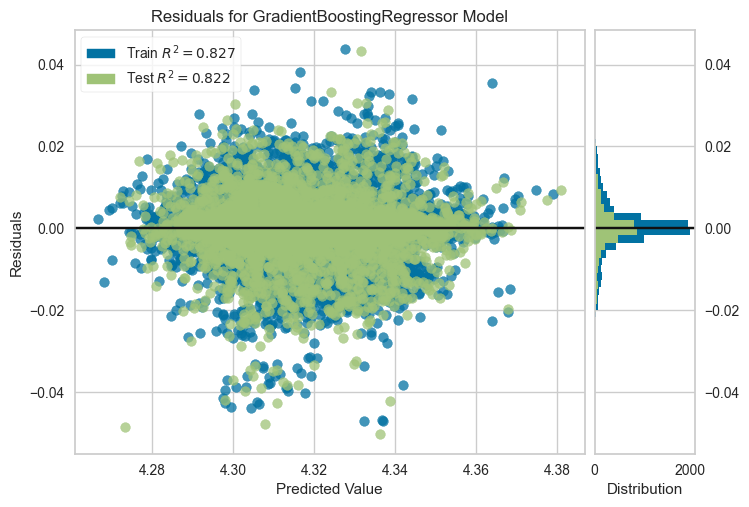

In [15]:
baseline_model.plot_model(tuned_model, plot = 'residuals')

1. The model appears to perform well on both training and test data, as indicated by R-squared values of 0.82 for both sets. An R-squared value of 0.82 suggests that the model explains about 82% of the variance in your target variable, indicating a strong fit.

2. The presence of a slight positive trend in the residuals could imply that the model tends to overestimate for higher predicted values. This systematic error suggests a certain level of bias in the model. It might be beneficial to investigate the cause of this trend, as addressing it could improve model performance.

3. A cluster of residuals around the predicted value of 4.32 could imply the model struggles with accurately predicting certain outliers or specific data points. Depending on the impact of these points, you might want to investigate them further to understand why they're not being accurately captured by the model.

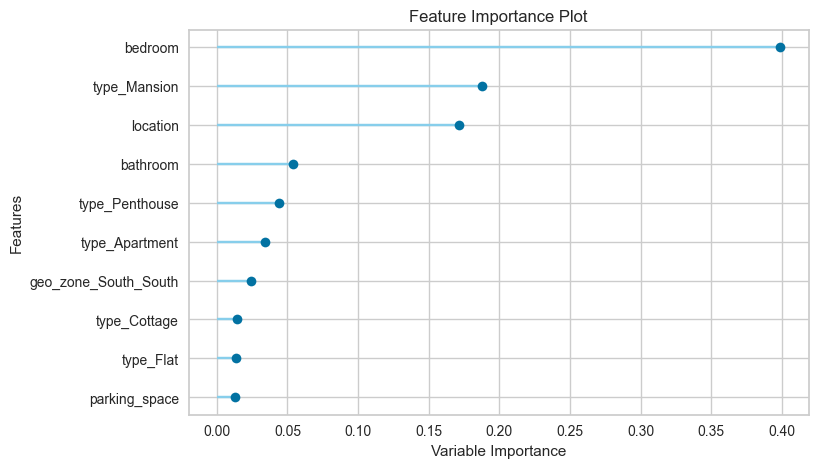

In [20]:
baseline_model.plot_model(tuned_model, plot = 'feature')

The model suggests that the number of bedrooms is the most crucial factor, followed by property type, location, and the number of bathrooms. The geo_zone and parking space attributes are less influential. This data can inform property pricing strategies, help identify undervalued or overvalued properties, and improve the accuracy of machine learning models. It's important to note, however, that these findings are based on a specific model and dataset and may not apply universally.

In [ ]:
# baseline_model.interpret_model(tuned_model)

In [ ]:
# The dashboard function generates the interactive dashboard for a trained model. 
#The dashboard is implemented using ExplainerDashboard 
baseline_model.dashboard(tuned_model,display_format='external')

In [29]:
final_model_tuned = baseline_model.finalize_model(tuned_model)

In [20]:
# Prediction on Unseen Data
predict_unseen_tuned = baseline_model.predict_model(final_model_tuned, data=test);
predict_unseen_tuned.head()

,location,type,bedroom,bathroom,parking_space,geo_zone,prediction_label
0,Kano,Penthouse,4,1,2,2,2.124968e+06
1,Adamawa,Apartment,2,2,4,1,1.071485e+06
2,Adamawa,Bungalow,2,7,2,1,1.236570e+06
3,Lagos,Mansion,9,5,2,5,8.092590e+06
4,Gombe,Semi-detached duplex,5,6,1,1,1.877503e+06


In [21]:
# Generating CSV for zindi Submissions 
sub = pd.DataFrame({
        "Id": Sample_submission['ID'],
        "Price": predict_unseen_tuned['prediction_label']
    })

sub.to_csv('submission8_tuned.csv', index=False)

In [32]:
#saving our model to the model folder
baseline_model.save_model(final_model_tuned, '../models/GBR(Tuned)_model_v1')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\OLUWAS~1\AppData\Local\Temp\joblib),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['bedroom', 'bathroom',
                                              'parking_space'],
                                     transformer=SimpleImputer())),
                 ('categoric...
                  TransformerWrapper(include=['location'],
                                     transformer=TargetEncoder(cols=['location'],
                                                               handle_missing='return_nan'))),
                 ('remove_outliers',
                  TransformerWrapper(transformer=RemoveOutliers(random_state=2023))),
                 ('actual_estimator',
                  GradientBoostingRegressor(learning_rate=0.15,
             

### Advanced training techniques using Ensemble Model

In [22]:
bagged_model = baseline_model.ensemble_model(tuned_model, 
                                             fold=10,
                                             method="Bagging",
                                             choose_better=True,
                                             optimize="RMSE",
                                             )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,263712.0715,298151485223.2267,546032.4947,0.7683,0.1860,0.1193
1,273982.9048,375166181388.5619,612508.1072,0.7243,0.1964,0.1171
2,238036.0267,246249648468.0442,496235.4768,0.7710,0.1754,0.1059
3,242862.8515,173006141734.9210,415940.0699,0.8166,0.1832,0.1184
4,274764.0339,428659282075.8687,654720.7665,0.6832,0.1949,0.1171
5,281492.2688,422359116167.4905,649891.6188,0.6698,0.2067,0.1217
6,246842.9941,259182283983.1632,509099.4834,0.7597,0.1829,0.1088
7,257363.8158,279812021404.3126,528972.6093,0.7338,0.1900,0.1132
8,224782.3859,182326891420.7310,426997.5309,0.8136,0.1703,0.1063


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

The ensemble_model function is ensembling previously tuned model. It is optimizing for the RMSE metric (Root Mean Squared Error), running for 10 folds of cross-validation. The choose_better parameter ensures that if the ensemble model does not improve the RMSE by at least 0.01%, it will return the original, non-ensembled model.

Looking at the results, the Mean RMSE for your bagged model is 529645.8759, with a standard deviation of 82253.7450. This means that, on average,the model's predictions are about 529645.8759 units away from the actual values. If we compare this with the Mean RMSE from the tuned model before bagging, which was 533609.1586, we can observe an improvement in the model's performance after bagging. Thus, ensemble learning through bagging has made the model more accurate in this case.

In [20]:
baseline_model.predict_model(bagged_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bagging Regressor,261061.5572,305925391897.3850,553105.2268,0.7523,0.1908,0.1151


i am using the predict_model function to make predictions on the hold-out set using the trained bagged model. The hold-out set is a portion of the original dataset that was separated out during model training. It has not been seen by the model before, hence it simulates unseen or new data.

Looking at your results, the RMSE for your bagged model on the hold-out set is 553,105.2268. If we compare this with the Mean RMSE from the cross-validated training, which was 529,645.8759, we can see that the model's performance is slightly worse on the unseen data. This is common as models tend to perform a bit worse on unseen data compared to the data they were trained on. However, the difference is not drastic, suggesting that the model has generalized well and is likely to perform similarly on other new, unseen data.

In [21]:
final_bagged_model = baseline_model.finalize_model(bagged_model)

In [22]:
# Prediction on Unseen Data
predict_unseen_bagged_model = baseline_model.predict_model(final_bagged_model, data=test);
predict_unseen_bagged_model.head()

,location,type,bedroom,bathroom,parking_space,geo_zone,prediction_label
0,Kano,Penthouse,4,1,2,North_West,2.244872e+06
1,Adamawa,Apartment,2,2,4,North_East,1.027406e+06
2,Adamawa,Bungalow,2,7,2,North_East,1.219960e+06
3,Lagos,Mansion,9,5,2,South_West,1.134098e+07
4,Gombe,Semi-detached duplex,5,6,1,North_East,1.822272e+06


In [23]:
# Generating CSV for zindi Submissions 
sub = pd.DataFrame({
        "Id": Sample_submission['ID'],
        "Price": predict_unseen_bagged_model['prediction_label']
    })

sub.to_csv('submission9_bagged_model.csv', index=False)

### Using blending method

In [24]:
blended_model = baseline_model.blend_models(
                                            estimator_list=[tuned_model, bagged_model],
                                            fold=10,
                                            optimize="RMSE",
                                            choose_better=True
                                            )

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:31:17
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Voting Regressor


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,266232.1978,294398603553.3508,542585.1118,0.7712,0.1866,0.1204
1,273457.3982,371111732388.5713,609189.4060,0.7273,0.1956,0.1174
2,240763.1448,243947092723.9741,493910.0047,0.7732,0.1762,0.1067
3,244978.1799,177282299489.7691,421049.0464,0.8121,0.1836,0.1188
4,274582.9546,432014350643.8826,657277.9858,0.6807,0.1960,0.1172
5,280739.1456,421168432081.1003,648974.9087,0.6707,0.2069,0.1216
6,247844.1100,259595239706.5780,509504.8966,0.7593,0.1831,0.1096
7,257798.3008,277967774381.2416,527226.4925,0.7355,0.1891,0.1130
8,225392.1807,183717233183.8561,428622.4833,0.8121,0.1707,0.1064


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

Looking at your results, the RMSE of the blended model during training (using cross-validation) is 529,587.1495, which is slightly better than the individual models.

In [25]:
baseline_model.predict_model(blended_model);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,263871.3660,308445565597.4942,555378.7587,0.7503,0.1910,0.1160


Then, when testing the blended model on unseen data, the RMSE is 555,378.7587.

In [37]:
final_blended_model = baseline_model.finalize_model(blended_model)

In [38]:
# Prediction on Unseen Data
predict_unseen_blended_model = baseline_model.predict_model(final_blended_model, data=test);
predict_unseen_blended_model.head()

,location,type,bedroom,bathroom,parking_space,geo_zone,prediction_label
0,Kano,Penthouse,4,1,2,2,2.295154e+06
1,Adamawa,Apartment,2,2,4,1,9.937285e+05
2,Adamawa,Bungalow,2,7,2,1,1.233363e+06
3,Lagos,Mansion,9,5,2,5,1.041234e+07
4,Gombe,Semi-detached duplex,5,6,1,1,1.801237e+06


In [39]:
# Generating CSV for zindi Submissions 
sub = pd.DataFrame({
        "Id": Sample_submission['ID'],
        "Price": predict_unseen_blended_model['prediction_label']
    })

sub.to_csv('submission7_blended_model.csv', index=False)